# SPICY Tutorial 5
This is the fifth tutorial exercise which deals with the stokes flow around a sphere. 

We start again by importing the relevant packages and customizing the plots. For this, LaTeX needs to be installed.

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy.io
from spicy_class_2103 import spicy

# This is for plot customization
fontsize = 16
plt.rc('text', usetex=True)      
plt.rc('font', family='serif')
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize
plt.rcParams['axes.labelsize'] = fontsize
plt.rcParams['legend.fontsize'] = fontsize
plt.rcParams['font.size'] = fontsize

This test case is the 3D stokes flow past a sphere which is a typical benchmark test case. The flow has a free-stream velocity of $U_0$ around a sphere of radius $1$. The domain of interest is the thick shell which lies in $r \in [1, 2]$.  The theoretical solution of the flow field is available analytically and given by

$$
\begin{align}
u_r &= U_0 \left(1-\frac{3}{2}\frac{R}{r} + \frac{1}{2} \left(\frac{R}{r}\right)^3 \text{cos}(\theta) \right) \\
u_\theta &= U_0 \left(1 -\frac{3}{4}\frac{R}{r} - \frac{1}{4} \left(\frac{R}{r}\right)^3 \text{sin}(\theta) \right)
\end{align}
$$

The individual cartesian velocity components are obtained by means of these equations

$$
\begin{align}
 U &= u_r \,\text{cos}(\varphi)\,\text{sin}(\theta) + u_\theta\,\text{cos}(\varphi)\,\text{cos}(\theta) \\
 V &= u_r \,\text{sin}(\varphi)\,\text{sin}(\theta) + u_\theta\,\text{sin}(\varphi)\,\text{cos}(\theta) \\
 W &= u_r \,\text{cos}(\theta) - u_\theta\,\text{sin}(\theta)
\end{align}
$$

In this case, $W$ is the main flow direction parallel to the free-stream velocity. The corresponding theoretical pressure field is

$$
P = - \frac{3}{2} \frac{\mu U_0 R}{r^2} \text{cos}(\theta)
$$

For the preparation of the dataset, we create $40000$ random points in a cube of $(x,y,z) = [-2,2]\times[-2,2]\times[-2,2]$. We then only keep the points which are in the region $r \in [1,2]$. For each of these points, the velocity is then computed and 5% is noise is added as this test case is more challenging than the previous ones.

In [2]:
# Fix random seed to ensure reproducibility
np.random.seed(42)

# Physical size of the domain
D = 1; D2 = 2; R = D/2
LX = 2; LY = 2; LZ = 2
# The sphere is centered in (0,0,0)
X_center_sphere = 0
Y_center_sphere = 0
Z_center_sphere = 0
# Properties of the flow
U_0 = 1; mu = 1; rho = 0

# Number of points in the Cube [-2x2, -2x2, -2x2]. The actual number of points in the sphere is slightly less than 
# half of that
n_p = 40000

# These are the points in the cube
X_cube = np.random.random(n_p)*LX-LX/2
Y_cube = np.random.random(n_p)*LY-LY/2
Z_cube = np.random.random(n_p)*LZ-LZ/2

# And here we only take the ones which are contained within the shell between r = 1 and r = 2
Insidespherebool = (X_cube-X_center_sphere)**2+(Y_cube-Y_center_sphere)**2+(Z_cube-Z_center_sphere)**2-(D/2)**2>0
X = X_cube[Insidespherebool]
Y = Y_cube[Insidespherebool]
Z = Z_cube[Insidespherebool]
Outsidespherebool = (X-X_center_sphere)**2+(Y-Y_center_sphere)**2+(Z-Z_center_sphere)**2-(D2/2)**2<0
X = X[Outsidespherebool]
Y = Y[Outsidespherebool]
Z = Z[Outsidespherebool]
# Extract the actual number of points
n_p = X.size

# Calculating the velocities with the Stokes flow equations
phi = np.arctan2(Y-Y_center_sphere, X-X_center_sphere)
theta = np.arctan2(np.sqrt((X-X_center_sphere)**2 + (Y-Y_center_sphere)**2), (Z-Z_center_sphere))
r = np.sqrt((X-X_center_sphere)**2 + (Y-Y_center_sphere)**2 + (Z-Z_center_sphere)**2)
# Velocities in spherical coordinates
v_r = U_0*(1 - 3/2*R/r + 0.5*(R/r)**3)*np.cos(theta) 
v_th = -U_0*(1 - 3/4*R/r - 0.25*(R/r)**3)*np.sin(theta)
# Theoretical pressure field
P = -3/2*(mu*U_0*R/r**2)*np.cos(theta)
# Projected velocities
U = v_r*np.cos(phi)*np.sin(theta)+v_th*np.cos(phi)*np.cos(theta)
V = v_r*np.sin(phi)*np.sin(theta)+v_th*np.cos(theta)*np.sin(phi)
W = v_r*np.cos(theta)-v_th*np.sin(theta)

# Add 5% noise to the velocity field
q = 0.05
U_noise = U * (1 + q * np.random.uniform(-1, 1, size = U.shape))
V_noise = V * (1 + q * np.random.uniform(-1, 1, size = V.shape))
W_noise = W * (1 + q * np.random.uniform(-1, 1, size = W.shape))

## Velocity regression

We start with the regression of the velocity field.

#### Step 1: Initialize the SPICY class

In [3]:
SP_vel = spicy([U_noise,V_noise,W_noise], [X,Y,Z], basis='gauss')

#### Step 2: Peform the clustering

The cylinder has some global 'trends': Behind the cylinder, both the pressure and the velocity field do not experience sharp gradients. Therefore, it is useful to have some flat RBFs, which is why we add the third clustering level which gives very flat RBFs.

In [4]:
SP_vel.clustering([6,60,1200], r_mM=[0.1, 0.65], eps_l=0.78)

Clustering level 0 completed
Clustering level 1 completed
Clustering level 2 completed


#### Step 3: Define the boundary conditions

For the velocity field, we have Dirichlet and divergence-free conditions. On each of the five boundaries, we sample 150 constraint points, removing duplicates. The Dirichlet conditions are a velocity of $0$ at the top, bottom and cylinder wall as well as a parabolic profile at the inlet. In these points, we also enforce a divergence-free flow. At the outlet, a divergence-free flow is also enforced.

In [5]:
# Defining the constrint points (outer sphere)
N_phi_outer = 90 # We have N_phi_outer-2 different phi values on the outer sphere # 90
# These are the distinct phi values
phi_sphere_outer_ring = np.linspace(np.pi/N_phi_outer,np.pi*(N_phi_outer-1)/N_phi_outer,N_phi_outer-2)
# We compute the number of points which are on each of these different phi rings
NC_perth_outer = np.array(np.floor(N_phi_outer * np.sin(phi_sphere_outer_ring)), dtype=np.int)
# and remove the ones with 2 or less values
phi_sphere_outer_ring = phi_sphere_outer_ring[NC_perth_outer>=2]
NC_perth_outer = NC_perth_outer[NC_perth_outer>=2]
# We initialize the array collecting all of the theta and phi values with the values of the first ring
theta_sphere_outer = np.linspace(0,2*np.pi*(NC_perth_outer[0]-1)/NC_perth_outer[0],NC_perth_outer[0])
phi_sphere_outer = phi_sphere_outer_ring[0]*np.ones(len(theta_sphere_outer))
# Loop over the remaining rings
for k in np.arange(1,len(NC_perth_outer)):
    # Compute the Theta values on this Phi ring
    theta_sphere_outer_ring = np.linspace(0, 2*np.pi*(NC_perth_outer[k]-1)/NC_perth_outer[k], NC_perth_outer[k]-1)
    # Append them into the theta array
    theta_sphere_outer = np.hstack((theta_sphere_outer, theta_sphere_outer_ring))
    # Append the phi values. These are constant on each ring
    phi_sphere_outer = np.hstack((phi_sphere_outer, phi_sphere_outer_ring[k]*np.ones(len(theta_sphere_outer_ring))))
# Compute the 3D coordinates in X, Y, Z
X_Outer = 0.5*D2*np.cos(phi_sphere_outer)*np.sin(theta_sphere_outer) + X_center_sphere
Y_Outer = 0.5*D2*np.sin(phi_sphere_outer)*np.sin(theta_sphere_outer) + Y_center_sphere
Z_Outer = 0.5*D2*np.cos(theta_sphere_outer) + Z_center_sphere 

# Defining the constrint points (inner sphere)
N_phi_inner = 60 # We have N_phi_inner-2 different phi values on the inner sphere # 60
# These are the distinct phi values
phi_sphere_inner_ring = np.linspace(np.pi/N_phi_inner,np.pi*(N_phi_inner-1)/N_phi_inner,N_phi_inner-2)
# We compute the number of points which are on each of these different phi rings
NC_perth_inner=np.array(np.floor(N_phi_inner * np.sin(phi_sphere_inner_ring)),dtype=np.int)
# and remove the ones with 2 or less values
phi_sphere_inner_ring=phi_sphere_inner_ring[NC_perth_inner>=2]
NC_perth_inner=NC_perth_inner[NC_perth_inner>=2]
# We initialize the array collecting all of the theta and phi values with the values of the first ring
theta_sphere_inner=np.linspace(0,2*np.pi*(NC_perth_inner[0]-1)/NC_perth_inner[0],NC_perth_inner[0])
phi_sphere_inner=phi_sphere_inner_ring[0]*np.ones(len(theta_sphere_inner))
# Loop over the remaining rings
for k in np.arange(1, len(NC_perth_inner)):
    # Compute the Theta values on this Phi ring
    theta_sphere_inner_ring = np.linspace(0,2*np.pi*(NC_perth_inner[k]-1)/NC_perth_inner[k],NC_perth_inner[k]-1)
    # Append them into the theta array
    theta_sphere_inner = np.hstack((theta_sphere_inner,theta_sphere_inner_ring))
    # Append the phi values. These are constant on each ring
    phi_sphere_inner = np.hstack((phi_sphere_inner,phi_sphere_inner_ring[k]*np.ones(len(theta_sphere_inner_ring))))
# Compute the 3D coordinates in X, Y, Z
X_Inner = 0.5*D*np.cos(phi_sphere_inner)*np.sin(theta_sphere_inner) + X_center_sphere
Y_Inner = 0.5*D*np.sin(phi_sphere_inner)*np.sin(theta_sphere_inner) + Y_center_sphere
Z_Inner = 0.5*D*np.cos(theta_sphere_inner) + Z_center_sphere

X_Div = np.concatenate((X_Outer, X_Inner))
Y_Div = np.concatenate((Y_Outer, Y_Inner))
Z_Div = np.concatenate((Z_Outer, Z_Inner))

_, valid_idcs = np.unique(np.column_stack((X_Div, Y_Div, Z_Div)), return_index = True, axis = 0)
X_Div = X_Div[valid_idcs]
Y_Div = Y_Div[valid_idcs]
Z_Div = Z_Div[valid_idcs]

X_Dir = X_Inner
Y_Dir = Y_Inner
Z_Dir = Z_Inner
_, valid_idcs = np.unique(np.column_stack((X_Dir, Y_Dir, Z_Dir)), return_index = True, axis = 0)
X_Dir = X_Dir[valid_idcs]
Y_Dir = Y_Dir[valid_idcs]
Z_Dir = Z_Dir[valid_idcs]
U_Dir = np.zeros(X_Dir.shape[0])
V_Dir = np.zeros(X_Dir.shape[0])
W_Dir = np.zeros(X_Dir.shape[0])

DIV = [X_Div, Y_Div, Z_Div]
DIR = [X_Dir, Y_Dir, Z_Dir, U_Dir, V_Dir, W_Dir]

# We set the constraints in these points and also place additional RBFs in each of these points
SP_vel.vector_constraints(DIR=DIR, DIV=DIV, extra_RBF=True)

2106 D conditions assigned
0 N conditions assigned
6980 Div conditions assigned


We can look at the clustering result. For 3D, the spheres are not visualized as it is hard to give any meaning to this rendering. Instead, only the diameter distribution is shown.

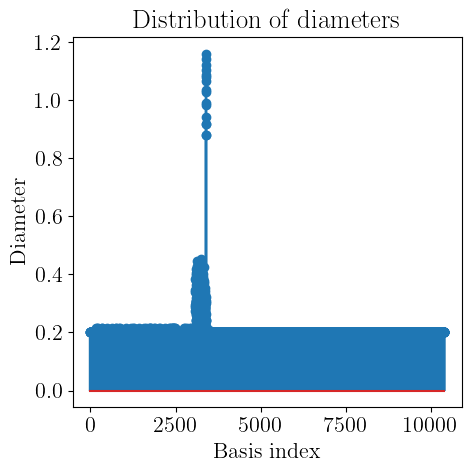

In [6]:
SP_vel.plot_RBFs()

#### Step 4: Assemble the linear system
We assemble the regression, with a penalty for a divergence-free flow.

In [7]:
SP_vel.Assembly_Regression(alpha_div=25, n_hb=0)

#### Step 5: Solve the linear system
We solve the system, with a fixed condition number of $10^8$ for the matrix $A$. The matrix $M$ is only regularized in this way if the cholesky factorization fails. This is the case here, so we make use of the regularization for $M$ as well with the same conditioning number.

In [8]:
SP_vel.Solve(K_cond=1e12)

Solving with constriaints
Matrix A regularized
Chol factor of M WITH regularization
Lambdas computed
w computed


#### Step 6: Obtain the solution
Here, we use the same grid points as before for an easier comparison, However, this grid can be completely arbitrary!

In [9]:
solution = SP_vel.Get_Sol(grid = [X,Y,Z])
# Extract individual velocity components
U_calc = solution[0*n_p:1*n_p]
V_calc = solution[1*n_p:2*n_p]
W_calc = solution[2*n_p:3*n_p]

We can now compute the error in the magnitude.

In [10]:
# Magnitude of the RBF solution
U_magn_calc = np.sqrt(U_calc**2 + V_calc**2 + W_calc**2)
# Compute the magnitude of the analytical solution
U_magn = np.sqrt(U**2 + V**2 + W**2)
# Compute the error in the magnitude
error_magn = np.linalg.norm(U_magn_calc - U_magn) / np.linalg.norm(U_magn)
# Error in u
error_u = np.linalg.norm(U_calc - U) / np.linalg.norm(U)
# Error in v
error_v = np.linalg.norm(V_calc - V) / np.linalg.norm(V)
# Error in w
error_w = np.linalg.norm(W_calc - W) / np.linalg.norm(W)

print('Total velocity error: {0:.3f}%'.format(error_magn*100))
print('Velocity error in u:  {0:.3f}%'.format(error_u*100))
print('Velocity error in v:  {0:.3f}%'.format(error_v*100))
print('Velocity error in w:  {0:.3f}%'.format(error_w*100))

Total velocity error: 0.621%
Velocity error in u:  1.310%
Velocity error in v:  1.268%
Velocity error in w:  0.636%


We achieve a very good error below 2% on the global velocity magnitude.The figures below show the scatter plots of the velocity of the first $4000$ data points, projected into the $x-y$ plane for ease of plotting.

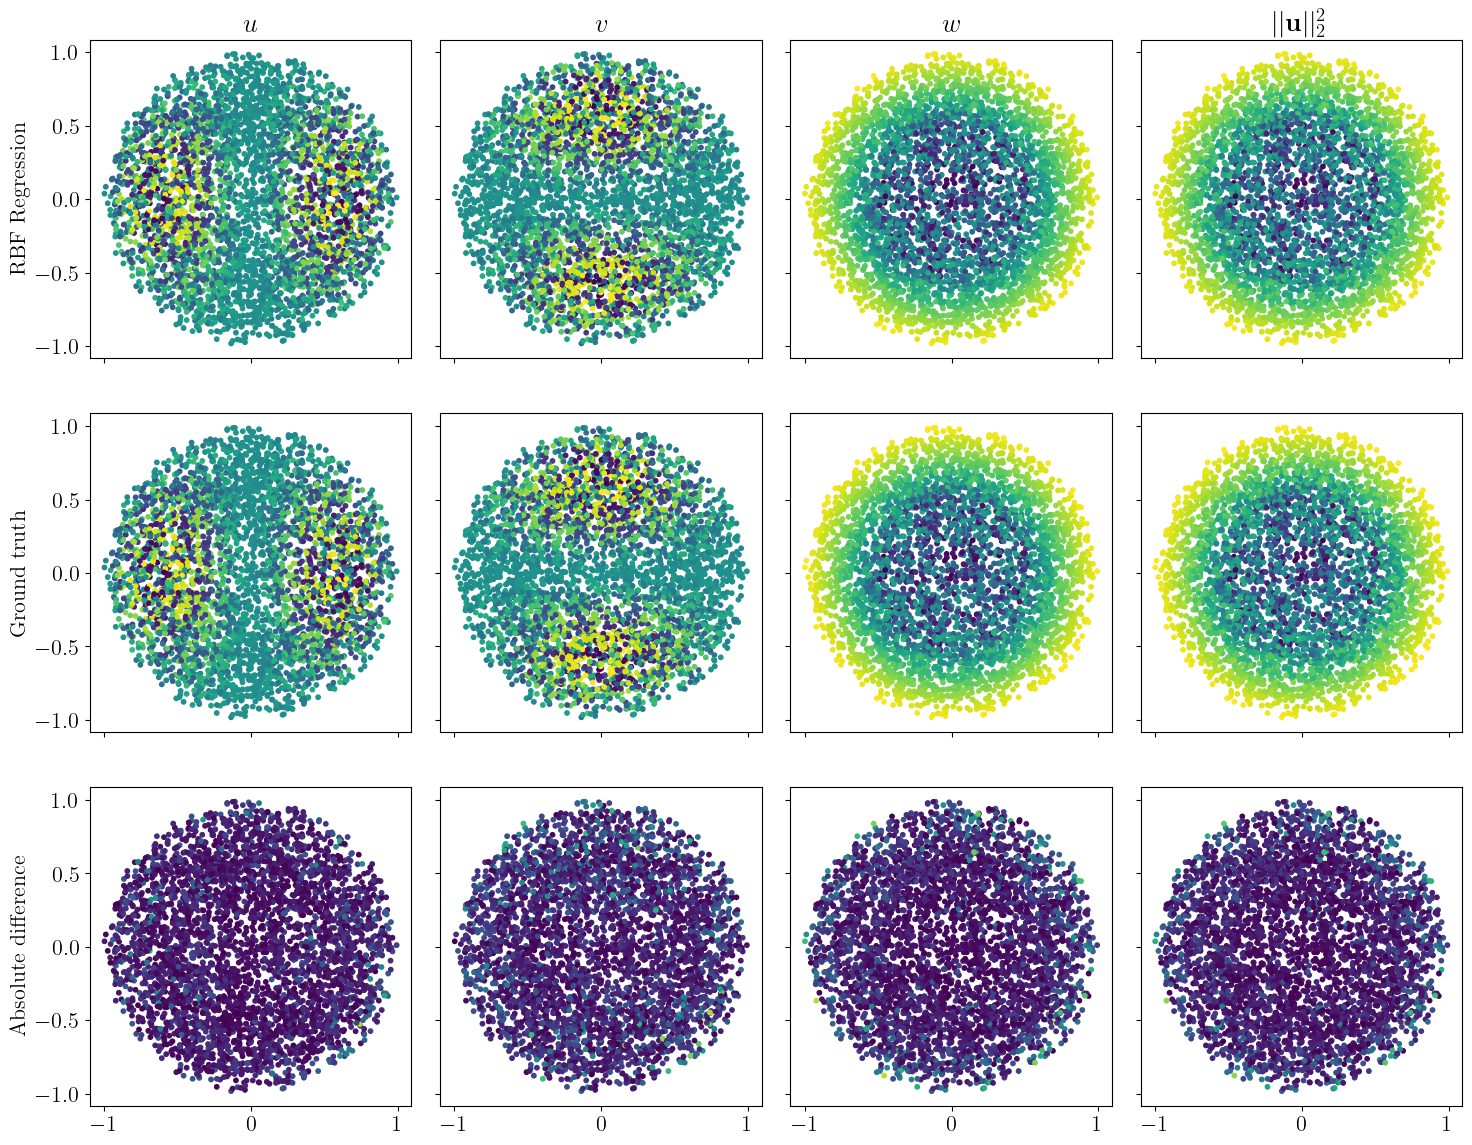

In [11]:
fig, axes = plt.subplots(ncols=4, nrows=3, figsize=(15,12), dpi=100, sharex=True, sharey=True)
axes[0,0].scatter(X[:4000], Y[:4000], c=U_calc[:4000], s=10)
axes[1,0].scatter(X[:4000], Y[:4000], c=U[:4000], s=10)
axes[2,0].scatter(X[:4000], Y[:4000], c=np.abs(U_calc[:4000]-U[:4000]), s=10) 

axes[0,1].scatter(X[:4000], Y[:4000], c=V_calc[:4000], s=10)
axes[1,1].scatter(X[:4000], Y[:4000], c=V[:4000], s=10)
axes[2,1].scatter(X[:4000], Y[:4000], c=np.abs(V_calc[:4000]-V[:4000]), s=10)  

axes[0,2].scatter(X[:4000], Y[:4000], c=W_calc[:4000], s=10)
axes[1,2].scatter(X[:4000], Y[:4000], c=W[:4000], s=10)
axes[2,2].scatter(X[:4000], Y[:4000], c=np.abs(W_calc[:4000]-W[:4000]), s=10) 

axes[0,3].scatter(X[:4000], Y[:4000], c=U_magn_calc[:4000], s=10)
axes[1,3].scatter(X[:4000], Y[:4000], c=U_magn[:4000], s=10)
axes[2,3].scatter(X[:4000], Y[:4000], c=np.abs(U_magn_calc[:4000]-U_magn[:4000]), s=10) 


axes[0,0].set_ylabel('RBF Regression') 
axes[1,0].set_ylabel('Ground truth')  
axes[2,0].set_ylabel('Absolute difference')  

axes[0,0].set_title('$u$') 
axes[0,1].set_title('$v$')  
axes[0,2].set_title('$w$')  
axes[0,3].set_title('$||\mathbf{u}||_2^2$')      
for ax in axes.flatten():
    ax.set_aspect(1)      
fig.tight_layout()      

From left to right, the figure shows the velocity component $u$, $v$, $w$ as well as the magnitude. From top to bottom the rows show the computed velocity, the ground truth and the absolute difference. The error appears very uniformly distributed. The error of $W$ and in the magnitude are very similar which is not surprising given that $W$ is the velocity component with the strongest magnitude.


## Pressure integration

For the pressure, we must compute two quantities from the velocity field. The first is the r.h.s. of equation (21) which is available analytically. The second are the values of the Neumann conditions on the boundaries, from equation (29).

We evaluate the source term on the original grid points, but this can also be an arbitrary grid.

In [12]:
# Get the source term
source_term = SP_vel.Evaluate_Source_Term(grid=[X,Y,Z], rho=rho)

For the boundary conditions, we must again define the points in which we want to compute them. To enhance the quality of the pressure reconstruction, we take $6$ synthetic pressure taps which are located on the sphere. In all of the divergence-free points, we take the Neumann boundary conditions for the pressure field based on the results from the velocity regression.

In [ ]:
# Simulated pressure taps on the sphere
X_taps = np.array([X_center_sphere,X_center_sphere,X_center_sphere,X_center_sphere,X_center_sphere+D/2,X_center_sphere-D/2])
Y_taps = np.array([Y_center_sphere,Y_center_sphere,Y_center_sphere+D/2,Y_center_sphere-D/2,Y_center_sphere,Y_center_sphere])
Z_taps = np.array([Z_center_sphere+D/2,Z_center_sphere-D/2,Z_center_sphere,Z_center_sphere,Z_center_sphere,Z_center_sphere])

# For the Dirichlet boundary conditions
# Get the pressure taps
X_Pres_D = X_taps
Y_Pres_D = Y_taps
Z_Pres_D = Z_taps
# And compute the pressure from the analytical solution
phi_Pres_D = np.arctan2(Y_Pres_D-Y_center_sphere, X_Pres_D-X_center_sphere)
theta_Pres_D = np.arctan2(np.sqrt((X_Pres_D-X_center_sphere)**2 + (Y_Pres_D-Y_center_sphere)**2), (Z_Pres_D-Z_center_sphere))
r_Pres_D = np.sqrt((X_Pres_D-X_center_sphere)**2 + (Y_Pres_D-Y_center_sphere)**2 + (Z_Pres_D-Z_center_sphere)**2)
P_Pres_D = -1.5*((mu*U_0*R/r_Pres_D**2))*np.cos(theta_Pres_D)

# Assemble the the entire array of Neumann points
X_Pres_N = np.concatenate((X_Outer, X_Inner))
Y_Pres_N = np.concatenate((Y_Outer, Y_Inner))
Z_Pres_N = np.concatenate((Z_Outer, Z_Inner))

# We assemble the normals in the same way
# Inner sphere
n_x_1 = np.cos(phi_sphere_outer)*np.sin(theta_sphere_outer)
n_y_1 = np.sin(phi_sphere_outer)*np.sin(theta_sphere_outer)
n_z_1 = np.cos(theta_sphere_outer)
# Outer sphere
n_x_2 = np.cos(phi_sphere_inner)*np.sin(theta_sphere_inner)
n_y_2 = np.sin(phi_sphere_inner)*np.sin(theta_sphere_inner)
n_z_2 = np.cos(theta_sphere_inner)
# Assemble to obtain the entire array of Neumann normals
n_x = np.concatenate((n_x_1, n_x_2))
n_y = np.concatenate((n_y_1, n_y_2))  
n_z = np.concatenate((n_z_1, n_z_2))

# Remove the duplicates for the normals
_, valid_idcs = np.unique(np.column_stack((X_Pres_N, Y_Pres_N, Z_Pres_N)), return_index = True, axis = 0)
X_Pres_N = X_Pres_N[valid_idcs]
Y_Pres_N = Y_Pres_N[valid_idcs]
Z_Pres_N = Z_Pres_N[valid_idcs]
n_x = n_x[valid_idcs]
n_y = n_y[valid_idcs]
n_z = n_z[valid_idcs]

# Evaluate the Neumann conditions in these points
P_Neu = SP_vel.Get_Pressure_Neumann(
    grid = [X_Pres_N, Y_Pres_N, Z_Pres_N], normals = [n_x, n_y, n_z], rho = rho, mu = mu)

Now, we have all of the quantities, that we need from the velocity. The velocity spicy class can now be deleted, to save memory but for the sake of this tutorial, all variables are kept.

#### Step 1: Initialize the SPICY class

In [ ]:
SP_pres = spicy([source_term], [X,Y,Z], basis='gauss')

#### Step 2: Peform the clustering

In [ ]:
SP_pres.clustering([6,60,1200], r_mM=[0.1, 0.65], eps_l=0.78)

#### Step 3: Define the boundary conditions
We use 195 Neumann and one Dirichlet boundary condition.

In [ ]:
# We assemble our Neumann and Dirichlet B.C.
NEU_P = [X_Pres_N, Y_Pres_N, Z_Pres_N, n_x, n_y, n_z, P_Neu]
DIR_P = [X_Pres_D, Y_Pres_D, Z_Pres_D, P_Pres_D]

# And, we set them
SP_pres.scalar_constraints(DIR=DIR_P, NEU=NEU_P, extra_RBF=True)

#### Step 4: Assemble the linear system
We assemble the regression, with no harmonic basis.

In [ ]:
SP_pres.Assembly_Poisson(n_hb=0)

#### Step 5: Solve the linear system
We solve the system, witha fixed condition number of $10^{12}$.

In [ ]:
SP_pres.Solve(K_cond=1e12)

#### Step 6 Obtain the solution

In [ ]:
P_calc = SP_pres.Get_Sol(grid=[X,Y,Z])

We can now compute the error in the magnitude

In [ ]:
# print the pressure error
error_p = np.linalg.norm(P - P_calc)/np.linalg.norm(P)
print('Total pressure error: {0:.3f}%'.format(error_p*100))

We close by comparing the calculated and ground truth pressure field.

In [ ]:
fig, axes = plt.subplots(figsize=(15,5), dpi=100, ncols=3, sharey=True)
axes[0].scatter(X[:4000], Y[:4000], c=P_calc[:4000], s=10)
axes[0].set_title('Computed pressure field')
axes[1].scatter(X[:4000], Y[:4000], c=P[:4000], s=10)
axes[1].set_title('Analytical pressure field')
axes[2].scatter(X[:4000], Y[:4000], c=np.abs(P_calc[:4000]-P[:4000]), s=10)
axes[2].set_title('Absolute difference')           
for ax in axes.flatten():
    ax.set_aspect(1)
fig.tight_layout()

As expected, the difference in the pressure field is the strongest in the center, where the largest gradient is located. However, the error is neglibile given the fact that there is 10% noise on the velocity data.